## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions. It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG, which can operate over continuous action spaces.

This tutorial closely follows this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem Setup

We are trying to solve the classic **Inverted Pendulum** control problem. In this setting, the agent can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, the agent has to select from infinite actions ranging from `-10` to `+10`.

### Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value) given a state and an action.

DDPG uses two more techniques:

**First, it uses two Target networks.**

This way it adds stability to training. In short, the agent is learning from estimated
targets and Target networks are updated slowly, hence keeping the estimated targets
stable.

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, it learns from sampling all of the experience
accumulated so far.

### Note

This notebook is adopted from a tutorial on Keras website that can be found here: [Keras Tutorial](https://keras.io/examples/rl/ddpg_pendulum/)

The main difference is the modification in the Pendulum environment, which adds noise to the velocity of the pendulum, hence, making the control problem stochastic as opposed to the original deterministic problem. The new gym environment `gym_StochPendulum` must be installed first.


In [1]:
# !pip install gym > /dev/null 2>&1
# !pip install -e gym-StochPendulum > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import numpy as np
import numpy.random as npr

import tensorflow as tf
from tensorflow.keras import layers

from tqdm import trange

import gym
import gym_StochPendulum
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)              # error only

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math

from os import path
import glob
import io
import base64
import ipywidgets as widgets
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, run "env = wrap_env(env)"
"""
def show_video(path_to_video):
    if path.exists(path_to_video):
        mp4 = path_to_video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))))
    else:
        print('Video cannot be found...')

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale actions later.

In [5]:
""" set up the problem similar to the stochastic control problem for comparison 
the episode length is 10 and there are 200 steps, thus dt=0.05; also noise level sigma=1 """
problem = 'StochPendulum-v0'
kwargs = {'sigma': 1., 'dt': 0.05}
env = gym.make(problem, **kwargs)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  10.0
Min Value of Action ->  -10.0


To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution and adds it to the action (control).

In [6]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        """ formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process """
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        """ store x into x_prev
        makes next noise dependent on current one """
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence, we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

The `Buffer` class implements **Experience Replay**.

In [7]:
class Buffer():
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity        # number of "experiences" to store at max
        self.batch_size      = batch_size             # number of tuples to train on
        self.buffer_counter  = 0                      # number of times record() was called

        """ instead of list of tuples as the exp.replay concept go 
        we use different np.arrays for each tuple element """
        self.state_buffer      = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer     = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer     = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    """ (s,a,r,s') obervation tuple as input """
    def record(self, obs_tuple):
        """ set index to zero if buffer_capacity is exceeded, replacing old records """
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index]      = obs_tuple[0]
        self.action_buffer[index]     = obs_tuple[1]
        self.reward_buffer[index]     = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        """ train and update Actor & Critic networks """
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma*target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            """ use `-value` as we want to maximize the value given by the critic for actions """
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    """ compute the loss and update parameters """
    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)        # get sampling range
        batch_indices = np.random.choice(record_range, self.batch_size)      # randomly sample indices

        """ convert to tensors """
        state_batch      = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch     = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch     = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch     = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


""" update target parameters slowly based on rate `tau`, which is much less than one """
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b*tau + a*(1-tau))

Next we define the Actor and Critic networks. These are basic Dense models with `ReLU` activation.

**Note:** We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash the gradients to zero,
as we use the `tanh` activation.

In [8]:
def get_actor():
    """ initialize weights between -3e-3 and 3-e3 """
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    """ apply the upper bound for action """
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    """ states as input """
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    """ actions as input """
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    """ both are passed through seperate layer before concatenating """
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    """ outputs single value for given state-action """
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

In [9]:
""" returns an action sampled from Actor network plus some noise for exploration """
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    
    sampled_actions = sampled_actions.numpy() + noise                    # adding noise to action
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)    # make sure action is within bounds
    return [np.squeeze(legal_action)]

## Training hyperparameters

In [10]:
std_dev  = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev)*np.ones(1))

actor_model   = get_actor()
critic_model  = get_critic()

target_actor  = get_actor()
target_critic = get_critic()

""" make the weights equal initially """
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

""" learning rate for actor-critic models """
critic_lr = 0.002
actor_lr  = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer  = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
num_steps      = 200
gamma = 0.99              # discount factor for future rewards
tau   = 0.005             # used to update target networks

ep_reward_list  = []      # store cost history of each episode
avg_reward_list = []      # store average cost history of last few episodes

buffer = Buffer(50000, 64)

Now we implement the main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [12]:
""" training loop """
pbar = trange(total_episodes)
for ep in pbar:
    prev_state = env.reset()
    episodic_reward = 0

    for it in range(num_steps):
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)                 # action from policy with added noise for exploration
        state, reward, done, info = env.step(action)             # recieve state and reward from environment

        buffer.record((prev_state, action, reward, state))       # record the tuple in the buffer
        episodic_reward += -reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        """ end this episode when `done` is True """
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    
    avg_reward = np.mean(ep_reward_list[-40:])                   # mean of last 40 episodes
    pbar.set_postfix({'Avg Reward': avg_reward})
    avg_reward_list.append(avg_reward)

100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Avg Reward=696]


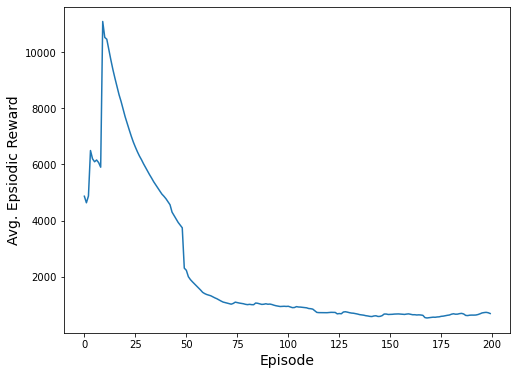

In [13]:
""" plot graph for episodes versus Avg. rewards """
fig = plt.figure(figsize=(8, 6))
plt.plot(avg_reward_list)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Avg. Epsiodic Reward', fontsize=14)
plt.show()


""" save the weights """
actor_model.save_weights('./saved-models/pendulum_actor.h5')
critic_model.save_weights('./saved-models/pendulum_critic.h5')

target_actor.save_weights('./saved-models/pendulum_target_actor.h5')
target_critic.save_weights('./saved-models/pendulum_target_critic.h5')

If training proceeds correctly, the average episodic cost will decrease with time. Note that the training may not achieve optimal control from one run to another as opposed to the deterministic pendulum. One can tune the parameters such as learning rates and the rate of update `tau` for target networks to achieve robust minimization of the cost function. Another way is to replace DDPG with more recent policy gradient algorithms that perform better under stochastic observations.

In [1]:
problem = 'StochPendulum-v0'
kwargs = {'sigma': 1., 'dt': 0.05}
eval_env = gym.make(problem, **kwargs)
prev_state = eval_env.reset()
episodic_reward = 0

for t in range(250):
    eval_env.render()
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
    action = policy(tf_prev_state, ou_noise)
    state, reward, done, info = eval_env.step(action)
    episodic_reward += -reward
    if done:
        print("Episode finished after {} timesteps with cost = {}".format(t+1, episodic_reward))
        break
    prev_state = state
eval_env.close()
show_video()

NameError: name 'gym' is not defined